# IBM Data Science Capstone Project 

## 1.0 Importing Data Sets

### 1.1 Toronto Borough and Neighborhood Data - Webscraping from Wikipedia, Appending Location Data 

In [19]:
# import relevant libraries

import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup

In [20]:
# webscrape data set - neighborhood data from Wikipedia

df = pd.read_html('https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050')[0]
df = df[df.Borough!='Not assigned']
df.shape

(210, 3)

In [21]:
#copy df

toronto_df = df.copy()

# importing neighborhood coordinates & appending the data
location_coordinates = pd.read_csv (r'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv')
location_coordinates.rename(columns={'Postal Code': 'Postcode'}, inplace=True)

toronto_loc_data = pd.merge(toronto_df, location_coordinates, on='Postcode', how='inner')
toronto_loc_data.shape

(210, 5)

### 1.2: Importing Household Income Data Set

In [22]:
# import household income of each Toronto neighbourhood

income_toronto_url = 'https://raw.githubusercontent.com/thatjosh/IBM-Data-Science-Capstone-Project/master/income_toronto.csv'
income_path = pd.read_csv(income_toronto_url)
df_income = pd.DataFrame(income_path)
df_income.drop(['Neighbourhood Id'], axis=1, inplace=True)
df_income.shape

(140, 2)

### 1.3: Importing Population Size Data Set

In [23]:
# load population of Southeast Asians in Toronto neighbourhoods

pop_toronto_url = 'https://raw.githubusercontent.com/thatjosh/IBM-Data-Science-Capstone-Project/master/population_toronto.csv'
pop_path = pd.read_csv(pop_toronto_url)
df_pop = pd.DataFrame(pop_path)
df_pop.drop(['Neighbourhood Id'], axis=1, inplace=True)
df_pop.shape

(140, 2)

### 1.4: Appending Data Sets

In [168]:
loc_stats = pd.merge(df_income, df_pop, on='Neighbourhood', how='inner')
final_loc_stats = pd.merge(loc_stats, toronto_loc_data, on='Neighbourhood', how='inner')
final_loc_stats.head(35)

,Neighbourhood,After-Tax Household Income,Total Population,Postcode,Borough,Latitude,Longitude
0,Markland Wood,64297.0,10554.0,M9C,Etobicoke,43.643515,-79.577201
1,New Toronto,40859.0,11463.0,M8V,Etobicoke,43.605647,-79.501321
2,Long Branch,47680.0,10084.0,M8W,Etobicoke,43.602414,-79.543484
3,Alderwood,61402.0,12054.0,M8W,Etobicoke,43.602414,-79.543484
4,Humber Summit,53272.0,12416.0,M9L,North York,43.756303,-79.565963
5,Bathurst Manor,51076.0,15873.0,M3H,North York,43.754328,-79.442259
6,Willowdale West,54226.0,16936.0,M2R,North York,43.782736,-79.442259
7,Victoria Village,43743.0,17510.0,M4A,North York,43.725882,-79.315572
8,Flemingdon Park,43511.0,21933.0,M3C,North York,43.725900,-79.340923
9,Hillcrest Village,57682.0,16934.0,M2H,North York,43.803762,-79.363452


### 1.5: Forsquare to Count Number of Potential Vendors - Markland Wood

In [227]:
# include relevant details
CLIENT_ID = 'RKVAUDN2014ZXME2CXFJMUMNQLE1J4RS3H5DRYBCRSCFLQOW' # your Foursquare ID
CLIENT_SECRET = 'ME4IPSPL2KS0NKU232TJNP2I01HGEOWSTU3SBOBH5XKNAOCK' # your Foursquare Secret
ACCESS_TOKEN = 'OPEO55QB2L5VWCJTZNKCZAPDDJV4LWANNIGAGS3G1FSOZILE'
VERSION = '20180605' # Foursquare API version
LIMIT = 300 # A default Foursquare API limit value
categoryId = '4d4b7105d754a06374d81259'

# import relevant libraries
from pandas.io.json import json_normalize

In [228]:
# import location data from Forsquare

# other conditions
radius = 5000
search_query = 'Restaurant'


latitude = 43.643515
longitude = -79.577201

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT, categoryId)
url

'https://api.foursquare.com/v2/venues/search?client_id=RKVAUDN2014ZXME2CXFJMUMNQLE1J4RS3H5DRYBCRSCFLQOW&client_secret=ME4IPSPL2KS0NKU232TJNP2I01HGEOWSTU3SBOBH5XKNAOCK&ll=43.643515,-79.577201&oauth_token=OPEO55QB2L5VWCJTZNKCZAPDDJV4LWANNIGAGS3G1FSOZILE&v=20180605&query=Restaurant&radius=5000&limit=300'

In [229]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '60ce050a664ecb5960b03679'},
 'notifications': [{'type': 'notificationTray', 'item': {'unreadCount': 0}}],
 'response': {'venues': [{'id': '4b533ffdf964a5201a9427e3',
    'name': 'Muddy Duck Restaurant',
    'location': {'address': '2200 Dundas St. E',
     'crossStreet': 'btw Regional Rd. 4 & Highway 407',
     'lat': 43.62597233051833,
     'lng': -79.56542718415807,
     'labeledLatLngs': [{'label': 'display',
       'lat': 43.62597233051833,
       'lng': -79.56542718415807}],
     'distance': 2171,
     'postalCode': 'L4X 2V3',
     'cc': 'CA',
     'neighborhood': 'Islington - City Centre West',
     'city': 'Mississauga',
     'state': 'ON',
     'country': 'Canada',
     'formattedAddress': ['2200 Dundas St. E (btw Regional Rd. 4 & Highway 407)',
      'Mississauga ON L4X 2V3',
      'Canada']},
    'categories': [{'id': '4bf58dd8d48988d14e941735',
      'name': 'American Restaurant',
      'pluralName': 'American Restaurants',
      'shortNa

In [230]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
MW_df = json_normalize(venues)
MW_df.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.neighborhood,location.city,location.state,location.country,location.formattedAddress,venuePage.id
0,4b533ffdf964a5201a9427e3,Muddy Duck Restaurant,"[{'id': '4bf58dd8d48988d14e941735', 'name': 'A...",v-1624114442,False,2200 Dundas St. E,btw Regional Rd. 4 & Highway 407,43.625972,-79.565427,"[{'label': 'display', 'lat': 43.62597233051833...",2171,L4X 2V3,CA,Islington - City Centre West,Mississauga,ON,Canada,[2200 Dundas St. E (btw Regional Rd. 4 & Highw...,NaN
1,50b633dee4b0efc209002435,The Olive Restaurant,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",v-1624114442,False,100 The East Mall,North Queen,43.619846,-79.549690,"[{'label': 'display', 'lat': 43.619846, 'lng':...",3443,M8Z 5X2,CA,Islington - City Centre West,Etobicoke,ON,Canada,"[100 The East Mall (North Queen), Etobicoke ON...",NaN
2,4bdf6678e75c0f470617cb03,Silk Road Restaurant 丝绸之路,"[{'id': '52af3b913cf9994f4e043c06', 'name': 'X...",v-1624114442,False,1852 Dundas St E,at Wharton Way,43.619278,-79.573031,"[{'label': 'display', 'lat': 43.61927817099883...",2718,L4X 1L9,CA,NaN,Mississauga,ON,Canada,"[1852 Dundas St E (at Wharton Way), Mississaug...",NaN
3,534b2c4c498e3290a42bc2f1,Cross Eyed Bear Restaurant,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",v-1624114442,False,555 Burnhamthorpe,The West Mall,43.644725,-79.568009,"[{'label': 'display', 'lat': 43.64472458866585...",752,M9C 2Y3,CA,NaN,Etobicoke,ON,Canada,"[555 Burnhamthorpe (The West Mall), Etobicoke ...",NaN
4,5dd098c5bf319f0008b5ba8d,Kahramana Restaurant,"[{'id': '5bae9231bedf3950379f89e7', 'name': 'I...",v-1624114442,False,3415 Dixie Road Unit 4A,NaN,43.617805,-79.595215,"[{'label': 'display', 'lat': 43.617805, 'lng':...",3209,L4Y 4J6,CA,NaN,Mississauga,ON,Canada,"[3415 Dixie Road Unit 4A, Mississauga ON L4Y 4...",NaN


In [231]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in MW_df.columns if col.startswith('location.')] + ['id']
MW_df_filtered = MW_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
MW_df_filtered['categories'] = MW_df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
MW_df_filtered.columns = [column.split('.')[-1] for column in MW_df_filtered.columns]

MW_df_filtered

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,neighborhood,city,state,country,formattedAddress,id
0,Muddy Duck Restaurant,American Restaurant,2200 Dundas St. E,btw Regional Rd. 4 & Highway 407,43.625972,-79.565427,"[{'label': 'display', 'lat': 43.62597233051833...",2171,L4X 2V3,CA,Islington - City Centre West,Mississauga,ON,Canada,[2200 Dundas St. E (btw Regional Rd. 4 & Highw...,4b533ffdf964a5201a9427e3
1,The Olive Restaurant,Restaurant,100 The East Mall,North Queen,43.619846,-79.549690,"[{'label': 'display', 'lat': 43.619846, 'lng':...",3443,M8Z 5X2,CA,Islington - City Centre West,Etobicoke,ON,Canada,"[100 The East Mall (North Queen), Etobicoke ON...",50b633dee4b0efc209002435
2,Silk Road Restaurant 丝绸之路,Xinjiang Restaurant,1852 Dundas St E,at Wharton Way,43.619278,-79.573031,"[{'label': 'display', 'lat': 43.61927817099883...",2718,L4X 1L9,CA,NaN,Mississauga,ON,Canada,"[1852 Dundas St E (at Wharton Way), Mississaug...",4bdf6678e75c0f470617cb03
3,Cross Eyed Bear Restaurant,Restaurant,555 Burnhamthorpe,The West Mall,43.644725,-79.568009,"[{'label': 'display', 'lat': 43.64472458866585...",752,M9C 2Y3,CA,NaN,Etobicoke,ON,Canada,"[555 Burnhamthorpe (The West Mall), Etobicoke ...",534b2c4c498e3290a42bc2f1
4,Kahramana Restaurant,Iraqi Restaurant,3415 Dixie Road Unit 4A,NaN,43.617805,-79.595215,"[{'label': 'display', 'lat': 43.617805, 'lng':...",3209,L4Y 4J6,CA,NaN,Mississauga,ON,Canada,"[3415 Dixie Road Unit 4A, Mississauga ON L4Y 4...",5dd098c5bf319f0008b5ba8d
5,VAHALLA RESTAURANT,Scandinavian Restaurant,314 W Center Ave,NaN,43.640954,-79.564951,"[{'label': 'display', 'lat': 43.64095401822603...",1027,93291,CA,NaN,Vahalla,CA,Canada,"[314 W Center Ave, Vahalla CA 93291, Canada]",4e8f1efebe7b11a0c4fd3f19
6,Perkins Restaurant & Bakery,American Restaurant,600 Dixon Rd,at Martin Grove Rd,43.691977,-79.572811,"[{'label': 'display', 'lat': 43.69197748145365...",5406,M9W 1J1,CA,NaN,Toronto,ON,Canada,"[600 Dixon Rd (at Martin Grove Rd), Toronto ON...",4b80c40ef964a520e68a30e3
7,The Bounty Restaurant,Breakfast Spot,2206 Dundas St. E.,NaN,43.626234,-79.565054,"[{'label': 'display', 'lat': 43.62623443261957...",2158,L4X 1L9,CA,NaN,Mississauga,ON,Canada,"[2206 Dundas St. E., Mississauga ON L4X 1L9, C...",4bd8c3c43749952129f65985
8,Restaurant Savana,American Restaurant,NaN,NaN,43.652166,-79.641770,"[{'label': 'display', 'lat': 43.65216594462269...",5289,NaN,CA,NaN,NaN,NaN,Canada,[Canada],4b9e3781f964a5208fd236e3
9,Best Friend Chinese Restaurant 老友記小廚,Chinese Restaurant,"888 Dundas St. E., Unit D1B",NaN,43.597756,-79.594227,"[{'label': 'display', 'lat': 43.59775555918656...",5275,L4Y 4G6,CA,NaN,Mississauga,ON,Canada,"[888 Dundas St. E., Unit D1B, Mississauga ON L...",4c3285c6a0ced13abf56156e


In [232]:
# count number of restaurants
len(MW_df_filtered[['name']].drop_duplicates())

50

### 1.6: Forsquare to Count Number of Potential Vendors - All Neighbourhoods

In [233]:
# generate neighbourhood list

neighbourhood_list = list(final_loc_stats['Neighbourhood'])
neighbourhood_list[3]

'Alderwood'

In [252]:
# import location data from Forsquare

# other conditions
radius = 3000
search_query = 'Restaurant'

# set global variable
i=0

# make list for restaurant count
count_restaurant = []


for x in neighbourhood_list:
    
    i
    latitude = final_loc_stats.iloc[i]['Latitude']
    longitude = final_loc_stats.iloc[i]['Longitude']
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
    results = requests.get(url).json()
    i = i + 1
    
    # assign relevant part of JSON to venues
    venues = results['response']['venues']

    # tranform venues into a dataframe
    total_df = json_normalize(venues)
    total_df.head()
    
    count_restaurant.append(len(total_df[['name']].drop_duplicates()))
    print(len(total_df[['name']].drop_duplicates())) 


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:27: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


In [253]:
from pandas import DataFrame as df

count_restaurant_df = df(count_restaurant,columns=['Restaurant Count']) 

In [327]:
from pandas import DataFrame as df

final_loc_stats_2 = final_loc_stats

count_restaurant_df = df(count_restaurant,columns=['Restaurant Count']) 
final_loc_stats_2 = final_loc_stats_2.join(count_restaurant_df)
final_loc_stats_2

,Neighbourhood,After-Tax Household Income,Total Population,Postcode,Borough,Latitude,Longitude,Restaurant Count
0,Markland Wood,64297.0,10554.0,M9C,Etobicoke,43.643515,-79.577201,21
1,New Toronto,40859.0,11463.0,M8V,Etobicoke,43.605647,-79.501321,24
2,Long Branch,47680.0,10084.0,M8W,Etobicoke,43.602414,-79.543484,21
3,Alderwood,61402.0,12054.0,M8W,Etobicoke,43.602414,-79.543484,21
4,Humber Summit,53272.0,12416.0,M9L,North York,43.756303,-79.565963,35
5,Bathurst Manor,51076.0,15873.0,M3H,North York,43.754328,-79.442259,41
6,Willowdale West,54226.0,16936.0,M2R,North York,43.782736,-79.442259,48
7,Victoria Village,43743.0,17510.0,M4A,North York,43.725882,-79.315572,47
8,Flemingdon Park,43511.0,21933.0,M3C,North York,43.725900,-79.340923,39
9,Hillcrest Village,57682.0,16934.0,M2H,North York,43.803762,-79.363452,43


## 2.0 Exploratory Data Analysis

### 2.1: Folium Mapping

In [255]:
# import relevant libraries
    # tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize 
import json

    # Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
    
    #folium
!pip install folium
import folium

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 94 kB 6.6 MB/s  eta 0:00:01


In [266]:
map_Toronto = folium.Map(location=[43.6532, -79.3832], zoom_start=10)

# copy df to prevent folium from changing the df
toronto_loc_f1 = final_loc_stats.copy()

# add markers to map
for lat, lng, borough, df_inner in zip(toronto_loc_f1['Latitude'], toronto_loc_f1['Longitude'], toronto_loc_f1['Borough'], toronto_loc_f1['Neighbourhood']):
    label = '{}, {}'.format(toronto_loc_f1, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

In [260]:
# import matplotlib

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

### 2.2: Visualising (After Tax) Household Income 

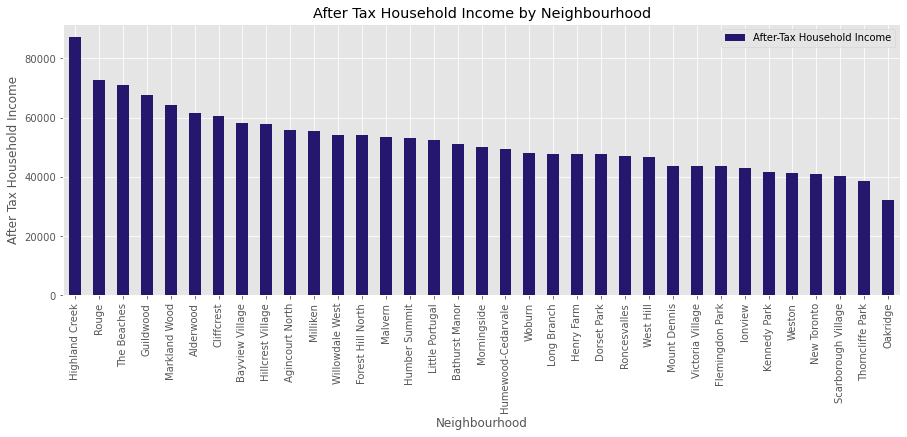

In [272]:
# define df
df_income = final_loc_stats_2[['Neighbourhood', 'After-Tax Household Income']].set_index('Neighbourhood')

# sort by descending order
df_income.sort_values(by='After-Tax Household Income', ascending=False, inplace=True)

# plot
mpl.style.use('ggplot')
df_income.plot(kind='bar', figsize=(15,5), color='#25176e')
plt.title('After Tax Household Income by Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('After Tax Household Income')

plt.show()

### 2.3: Visualising Population

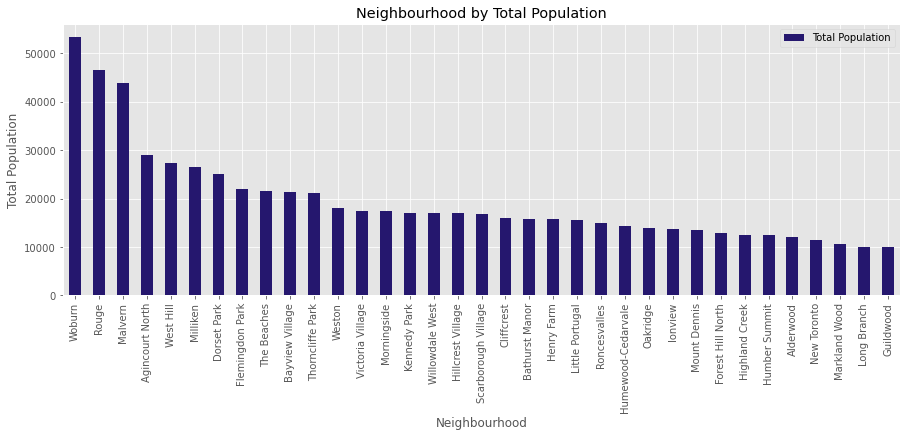

In [282]:
# define df
df_pop = final_loc_stats_2[['Neighbourhood', 'Total Population']].set_index('Neighbourhood')

# sort by descending order
df_pop.sort_values(by='Total Population', ascending=False, inplace=True)

# plot
mpl.style.use('ggplot')
df_pop.plot(kind='bar', figsize=(15,5), color='#25176e')
plt.title('Neighbourhood by Total Population')
plt.xlabel('Neighbourhood')
plt.ylabel('Total Population')

plt.show()

### 2.4: Visualising Number of Potential Vendors

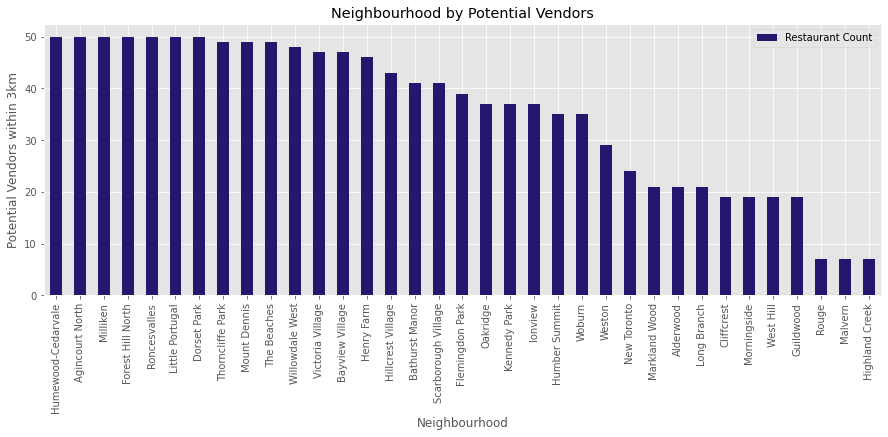

In [287]:
# define df
df_po_ven = final_loc_stats_2[['Neighbourhood', 'Restaurant Count']].set_index('Neighbourhood')

# sort by descending order
df_po_ven.sort_values(by='Restaurant Count', ascending=False, inplace=True)

# plot
mpl.style.use('ggplot')
df_po_ven.plot(kind='bar', figsize=(15,5), color='#25176e')
plt.title('Neighbourhood by Potential Vendors')
plt.xlabel('Neighbourhood')
plt.ylabel('Potential Vendors within 3km')

plt.show()

## 3.0 K-means Clustering

### 3.1: Preparing Data Set - Normalising Each Category

In [325]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [328]:
final_loc_stats_2

,Neighbourhood,After-Tax Household Income,Total Population,Postcode,Borough,Latitude,Longitude,Restaurant Count
0,Markland Wood,64297.0,10554.0,M9C,Etobicoke,43.643515,-79.577201,21
1,New Toronto,40859.0,11463.0,M8V,Etobicoke,43.605647,-79.501321,24
2,Long Branch,47680.0,10084.0,M8W,Etobicoke,43.602414,-79.543484,21
3,Alderwood,61402.0,12054.0,M8W,Etobicoke,43.602414,-79.543484,21
4,Humber Summit,53272.0,12416.0,M9L,North York,43.756303,-79.565963,35
5,Bathurst Manor,51076.0,15873.0,M3H,North York,43.754328,-79.442259,41
6,Willowdale West,54226.0,16936.0,M2R,North York,43.782736,-79.442259,48
7,Victoria Village,43743.0,17510.0,M4A,North York,43.725882,-79.315572,47
8,Flemingdon Park,43511.0,21933.0,M3C,North York,43.725900,-79.340923,39
9,Hillcrest Village,57682.0,16934.0,M2H,North York,43.803762,-79.363452,43


In [329]:
k=5
final_loc_stats_3 = final_loc_stats_2
cluster = final_loc_stats_3.drop(['Postcode', 'Borough', 'Neighbourhood','After-Tax Household Income','Total Population','Restaurant Count'], axis = 1)
cluster.rename(columns={0:'Household Income', 1:'Population Size', 2:'Latitude', 3: 'Longtitude', 4:'Restaurant Count'}, inplace=True)
cluster.head(5)

,Latitude,Longitude
0,43.643515,-79.577201
1,43.605647,-79.501321
2,43.602414,-79.543484
3,43.602414,-79.543484
4,43.756303,-79.565963


In [330]:
kmeans = KMeans(n_clusters = k,random_state=0).fit(cluster)
kmeans.labels_

Toronto_data = final_loc_stats_3
Toronto_data.insert(0, 'Cluster Labels', kmeans.labels_)
Toronto_data

,Cluster Labels,Neighbourhood,After-Tax Household Income,Total Population,Postcode,Borough,Latitude,Longitude,Restaurant Count
0,3,Markland Wood,64297.0,10554.0,M9C,Etobicoke,43.643515,-79.577201,21
1,3,New Toronto,40859.0,11463.0,M8V,Etobicoke,43.605647,-79.501321,24
2,3,Long Branch,47680.0,10084.0,M8W,Etobicoke,43.602414,-79.543484,21
3,3,Alderwood,61402.0,12054.0,M8W,Etobicoke,43.602414,-79.543484,21
4,3,Humber Summit,53272.0,12416.0,M9L,North York,43.756303,-79.565963,35
5,0,Bathurst Manor,51076.0,15873.0,M3H,North York,43.754328,-79.442259,41
6,0,Willowdale West,54226.0,16936.0,M2R,North York,43.782736,-79.442259,48
7,2,Victoria Village,43743.0,17510.0,M4A,North York,43.725882,-79.315572,47
8,2,Flemingdon Park,43511.0,21933.0,M3C,North York,43.725900,-79.340923,39
9,4,Hillcrest Village,57682.0,16934.0,M2H,North York,43.803762,-79.363452,43


In [331]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_data['Latitude'], Toronto_data['Longitude'], Toronto_data['Neighbourhood'], Toronto_data['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 3.2: Finding the Best Value for K

Solving environment: done

# All requested packages already installed.



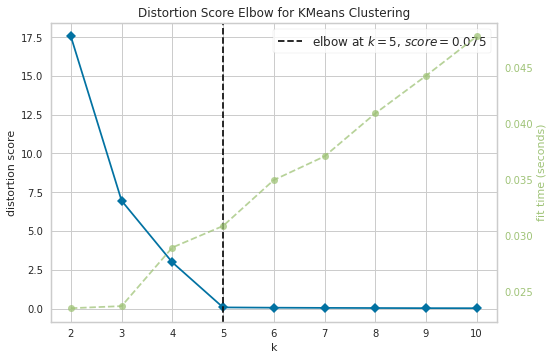

In [363]:
final_loc_stats_4 = final_loc_stats_2
cluster_2 = final_loc_stats_3.drop(['Postcode', 'Borough', 'Neighbourhood','After-Tax Household Income','Total Population','Restaurant Count'], axis = 1)
cluster_2.rename(columns={0:'Household Income', 1:'Population Size', 2:'Latitude', 3: 'Longtitude', 4:'Restaurant Count'}, inplace=True)

from sklearn.cluster import KMeans
!conda install -c districtdatalabs yellowbrick

from yellowbrick.cluster import KElbowVisualizer


# Instantiate the clustering model and visualiser
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,11))

visualizer.fit(cluster_2)        # Fit the data to the visualiser
visualizer.show()        # Finalise and render the figure

## 4.0 Analysing Each Cluster### 3.4: Cluster Results

### 4.1: Cluster 0

In [439]:
Tonronto_data_C0 = Toronto_data.drop(['Postcode', 'Borough'], axis = 1)
Tonronto_data_C0 = Tonronto_data_C0[Tonronto_data_C0["Cluster Labels"].isin([0])]
Tonronto_data_C0_mean = Tonronto_data_C0.mean()
Tonronto_data_C0_mean 

,Cluster Labels,Neighbourhood,After-Tax Household Income,Total Population,Latitude,Longitude,Restaurant Count
5,0,Bathurst Manor,51076.0,15873.0,43.754328,-79.442259,41
6,0,Willowdale West,54226.0,16936.0,43.782736,-79.442259,48
14,0,Little Portugal,52519.0,15559.0,43.647927,-79.419750,50
15,0,Roncesvalles,46883.0,14974.0,43.648960,-79.456325,50
16,0,Forest Hill North,53978.0,12806.0,43.696948,-79.411307,50
17,0,Humewood-Cedarvale,49252.0,14365.0,43.693781,-79.428191,50
19,0,Mount Dennis,43790.0,13593.0,43.691116,-79.476013,49


In [476]:
stats_neighbourhood = pd.DataFrame (columns = ['Cluster Labels','After-Tax Household Income','Total Population', 'Latitude', 'Longitude', 'Restaurant Count'])

Tonronto_data_C = Toronto_data.drop(['Postcode', 'Borough'], axis = 1)
Tonronto_data_C0 = Tonronto_data_C[Tonronto_data_C["Cluster Labels"].isin([1])]
Toronto_data_C0_mean = Tonronto_data_C0.mean().to_frame().transpose()

stats_neighbourhood = stats_neighbourhood.append(Toronto_data_C0_mean, ignore_index = True)
stats_neighbourhood

,Cluster Labels,After-Tax Household Income,Total Population,Latitude,Longitude,Restaurant Count
0,1.0,58271.125,28469.625,43.775544,-79.196466,19.25


### 4.2: All Clusters

In [495]:
i = 0
stats_neighbourhood = pd.DataFrame (columns = ['Cluster Labels','After-Tax Household Income','Total Population', 'Latitude', 'Longitude', 'Restaurant Count'])

for x in range (0, 5):

    Tonronto_data_C = Toronto_data.drop(['Postcode','Borough'], axis = 1)
    Tonronto_data_C0 = Tonronto_data_C[Tonronto_data_C["Cluster Labels"].isin([i])]
    Toronto_data_C0_mean = Tonronto_data_C0.mean().to_frame().transpose()

    stats_neighbourhood = stats_neighbourhood.append(Toronto_data_C0_mean, ignore_index = True)
    i = i + 1

stats_neighbourhood

,Cluster Labels,After-Tax Household Income,Total Population,Latitude,Longitude,Restaurant Count
0,0.0,50246.285714,14872.285714,43.702257,-79.439444,48.285714
1,1.0,58271.125000,28469.625000,43.775544,-79.196466,19.250000
2,2.0,46855.111111,18629.444444,43.719356,-79.291146,40.444444
3,3.0,51477.666667,12427.166667,43.652861,-79.541607,25.166667
4,4.0,54945.200000,21947.600000,43.799946,-79.333027,47.200000


In [506]:
from sklearn import preprocessing

# drop non-variable columns 
stats_neighbourhood_norm = stats_neighbourhood.drop(['Cluster Labels','Latitude','Longitude', ], axis = 1)

x = stats_neighbourhood_norm.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_normalised = pd.DataFrame(x_scaled)
df_normalised

,0,1,2
0,0.297054,0.152415,1.000000
1,1.000000,1.000000,0.000000
2,0.000000,0.386616,0.729944
3,0.404919,0.000000,0.203772
4,0.708661,0.593452,0.962608


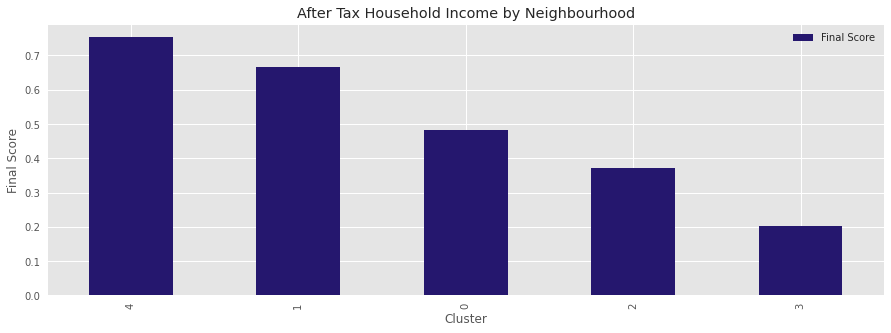

In [520]:
df_normalised_final = df_normalised.mean(axis=1).to_frame()
df_normalised_final .rename(columns={0:'Final Score'}, inplace=True)
df_normalised_final.sort_values(by='Final Score', ascending=False, inplace=True)

# plot graph
mpl.style.use('ggplot')
df_normalised_final.plot(kind='bar', figsize=(15,5), color='#25176e')
plt.title('After Tax Household Income by Neighbourhood')
plt.xlabel('Cluster')
plt.ylabel('Final Score')

plt.show()